In [17]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import motifs
from Bio.Seq import Seq
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import re
from sklearn.metrics import r2_score

# Set plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 300

In [2]:
# Load data from the original analysis
ct_interactions = {}
cell_types = ['Astro', 'Exc_deep', 'Exc_int', 'Exc_upper', 'Inh', 'Microglia', 'Oligo', 'OPC']
filters_root = '/home/aiden/codes/APA_stuff/APA_ALS_paper_rev_2024/filter_interactions'
for ct in cell_types:
    ct_interactions[ct] = pd.read_csv(os.path.join(filters_root, f'{ct}_corr.csv'), index_col=0)
    
micro_itx = ct_interactions['Microglia']
print(f"Loaded correlation matrix: {micro_itx.shape}")

Loaded correlation matrix: (92, 92)


In [3]:
# Function to read MEME file and extract PWMs
def read_meme_file(meme_file):
    pwm_dict = {}
    current_motif = None
    with open(meme_file, 'r') as f:
        for line in f:
            if line.startswith('MOTIF'):
                if current_motif:
                    pwm_dict[current_motif['name']] = current_motif['pwm']
                motif_name = line.split()[2]
                current_motif = {'name': motif_name, 'pwm': {'A': [], 'C': [], 'G': [], 'T': []}}
            elif current_motif and re.match(r'^\s*[\d\.]+\s+[\d\.]+\s+[\d\.]+\s+[\d\.]+\s*$', line):
                values = list(map(float, line.split()))
                current_motif['pwm']['A'].append(values[0])
                current_motif['pwm']['C'].append(values[1])
                current_motif['pwm']['G'].append(values[2])
                current_motif['pwm']['T'].append(values[3])
    if current_motif:
        pwm_dict[current_motif['name']] = current_motif['pwm']
    return pwm_dict

def sliding_pwm_similarity(pwm1, pwm2, min_overlap=4):
    """Slide pwm2 across pwm1, compute Pearson r for each overlap, return best correlation and offset."""
    arr1 = np.vstack([pwm1[b] for b in 'ACGT']).T
    arr2 = np.vstack([pwm2[b] for b in 'ACGT']).T
    L1, L2 = len(arr1), len(arr2)
    
    best_r, best_offset = -1, None
    for offset in range(-L2+min_overlap, L1-min_overlap+1):
        i1_start = max(0, offset)
        i1_end = min(L1, offset + L2)
        i2_start = max(0, -offset)
        i2_end = i2_start + (i1_end - i1_start)
        
        overlap1 = arr1[i1_start:i1_end].flatten()
        overlap2 = arr2[i2_start:i2_end].flatten()
        if len(overlap1) < 4*min_overlap:
            continue
        
        r = np.corrcoef(overlap1, overlap2)[0,1]
        if r > best_r:
            best_r, best_offset = r, offset
    
    return best_r, best_offset

In [4]:
# Rename RBPs to match MEME file
def rename_rbps(micro_itx):
    name_mapping = {
        'ELF4': 'BRUNOL4',
        'SF3B4': 'Sf3b4',
        'ELAVL1': 'HuR',
        'HNRNPLL': 'HNRPLL',
        'CELF5': 'BRUNOL5',
        'CELF3': 'BRUNOL3',
        'EIF2S1': 'EIF-2ALPHA',
        'CELF6': 'BRUNOL6',
        'SRSF6': 'SF2',
        'FMR1-IT1': 'FMR1',
        'CPOX': 'CPO',
        'SYNCRIP': 'Syncrip'
    }
    
    new_index = micro_itx.index.map(lambda x: name_mapping.get(x, x))
    micro_itx.index = new_index
    micro_itx.columns = new_index
    
    return micro_itx

micro_itx = rename_rbps(micro_itx)
print(f"Renamed correlation matrix shape: {micro_itx.shape}")

Renamed correlation matrix shape: (92, 92)


In [5]:
# Generate correlation-similarity data
def analyze_rbp_correlation_similarity(micro_itx, meme_file):
    pwm_dict = read_meme_file(meme_file)
    rbp_names = micro_itx.index.tolist()
    
    correlations = []
    similarities = []
    
    for i in range(len(rbp_names)):
        for j in range(i+1, len(rbp_names)):
            rbp1, rbp2 = rbp_names[i], rbp_names[j]
            correlation = micro_itx.loc[rbp1, rbp2]
            
            if rbp1 in pwm_dict and rbp2 in pwm_dict:
                similarity, _ = sliding_pwm_similarity(pwm_dict[rbp1], pwm_dict[rbp2])
                correlations.append(correlation)
                similarities.append(similarity)
    
    return pd.DataFrame({'Correlation': correlations, 'Similarity': similarities})

# Load the data
result_df = analyze_rbp_correlation_similarity(micro_itx, 'Ray2013_rbp_All_Species.meme')
print(f"Generated {len(result_df)} RBP pairs for analysis")
print(f"Correlation range: {result_df['Correlation'].min():.3f} to {result_df['Correlation'].max():.3f}")
print(f"Similarity range: {result_df['Similarity'].min():.3f} to {result_df['Similarity'].max():.3f}")

Generated 3655 RBP pairs for analysis
Correlation range: -0.474 to 1.000
Similarity range: -0.416 to 1.000


In [18]:
# Test different threshold combinations
def test_threshold_combination(df, corr_thr, sim_thr, test_type='fisher'):
    """
    Test statistical significance of high correlation + low similarity quadrant
    
    Parameters:
    df: DataFrame with Correlation and Similarity columns
    corr_thr: correlation threshold (pairs above this are "high correlation")
    sim_thr: similarity threshold (pairs below this are "low similarity")
    test_type: 'fisher' for Fisher's exact test, 'chi2' for chi-square test
    """
    
    # Create 2x2 contingency table
    high_corr_low_sim = len(df[(df['Correlation'] > corr_thr) & (df['Similarity'] < sim_thr)])
    high_corr_high_sim = len(df[(df['Correlation'] > corr_thr) & (df['Similarity'] >= sim_thr)])
    low_corr_low_sim = len(df[(df['Correlation'] <= corr_thr) & (df['Similarity'] < sim_thr)])
    low_corr_high_sim = len(df[(df['Correlation'] <= corr_thr) & (df['Similarity'] >= sim_thr)])
    
    # Contingency table
    contingency = np.array([
        [high_corr_low_sim, high_corr_high_sim],
        [low_corr_low_sim, low_corr_high_sim]
    ])
    
    total = contingency.sum()
    
    # Calculate expected frequencies under independence
    row_totals = contingency.sum(axis=1)
    col_totals = contingency.sum(axis=0)
    expected = np.outer(row_totals, col_totals) / total
    
    # Statistical tests
    if test_type == 'fisher':
        odds_ratio, p_value = stats.fisher_exact(contingency, alternative='greater')
        test_stat = odds_ratio
    elif test_type == 'chi2':
        test_stat, p_value, _, _ = stats.chi2_contingency(contingency)
        odds_ratio = (contingency[0,0] * contingency[1,1]) / (contingency[0,1] * contingency[1,0]) if contingency[0,1] * contingency[1,0] > 0 else np.inf
    
    # Calculate fold enrichment
    observed_prop = high_corr_low_sim / total
    expected_prop = expected[0,0] / total
    fold_enrichment = observed_prop / expected_prop if expected_prop > 0 else np.inf
    
    return {
        'corr_thr': corr_thr,
        'sim_thr': sim_thr,
        'contingency': contingency,
        'high_corr_low_sim': high_corr_low_sim,
        'total_pairs': total,
        'observed_prop': observed_prop,
        'expected_prop': expected_prop,
        'fold_enrichment': fold_enrichment,
        'odds_ratio': odds_ratio,
        'p_value': p_value,
        'test_stat': test_stat,
        'test_type': test_type
    }

In [7]:
# Test the main hypothesis: correlation > 0, similarity > 0
print("=== Testing Correlation > 0 and Similarity > 0 ===")
result_main = test_threshold_combination(result_df, corr_thr=0, sim_thr=0, test_type='fisher')

print(f"Correlation threshold: > {result_main['corr_thr']}")
print(f"Similarity threshold: < {result_main['sim_thr']}")
print(f"\nContingency table:")
print(f"                    Low Sim    High Sim")
print(f"High Corr           {result_main['contingency'][0,0]:8d}    {result_main['contingency'][0,1]:8d}")
print(f"Low Corr            {result_main['contingency'][1,0]:8d}    {result_main['contingency'][1,1]:8d}")
print(f"\nHigh Correlation + Low Similarity pairs: {result_main['high_corr_low_sim']}")
print(f"Total pairs: {result_main['total_pairs']}")
print(f"Observed proportion: {result_main['observed_prop']:.3f} ({result_main['observed_prop']*100:.1f}%)")
print(f"Expected proportion: {result_main['expected_prop']:.3f} ({result_main['expected_prop']*100:.1f}%)")
print(f"Fold enrichment: {result_main['fold_enrichment']:.2f}")
print(f"Odds ratio: {result_main['odds_ratio']:.2f}")
print(f"Fisher's exact test p-value: {result_main['p_value']:.2e}")

=== Testing Correlation > 0 and Similarity > 0 ===
Correlation threshold: > 0
Similarity threshold: < 0

Contingency table:
                    Low Sim    High Sim
High Corr                472        2592
Low Corr                 174         417

High Correlation + Low Similarity pairs: 472
Total pairs: 3655
Observed proportion: 0.129 (12.9%)
Expected proportion: 0.148 (14.8%)
Fold enrichment: 0.87
Odds ratio: 0.44
Fisher's exact test p-value: 1.00e+00


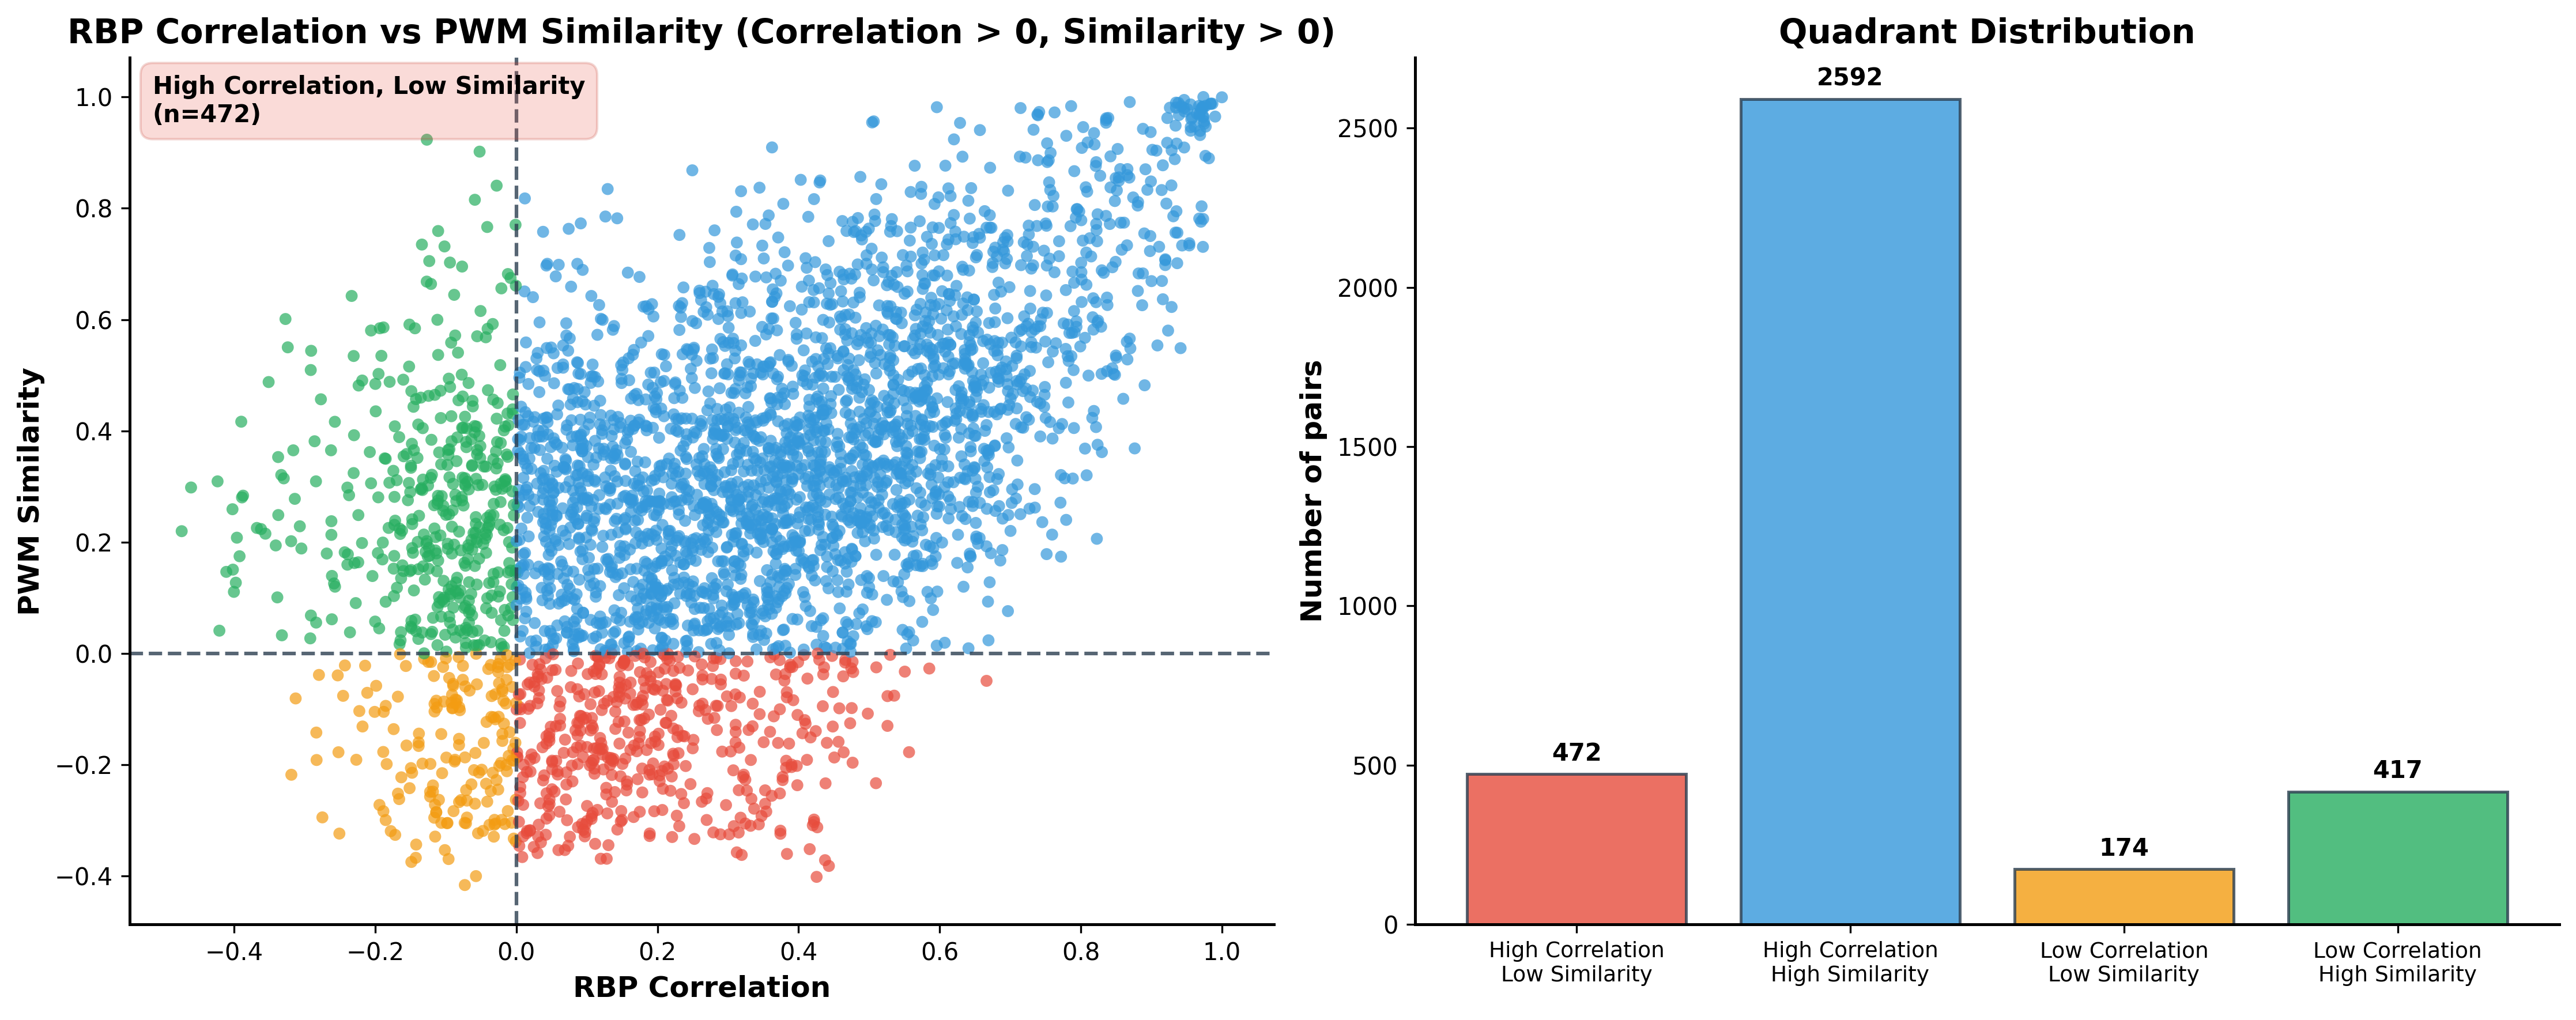

Plot saved as 'rbp_correlation_similarity_analysis.pdf'


In [20]:
# Visualize the main result
def plot_threshold_result(df, result, title_suffix=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot with thresholds
    corr_thr, sim_thr = result['corr_thr'], result['sim_thr']
    
    # Publication-ready color palette
    colors = []
    for _, row in df.iterrows():
        if row['Correlation'] > corr_thr and row['Similarity'] < sim_thr:
            colors.append('#E74C3C')  # High corr, low sim - red
        elif row['Correlation'] > corr_thr and row['Similarity'] >= sim_thr:
            colors.append('#3498DB')  # High corr, high sim - blue
        elif row['Correlation'] <= corr_thr and row['Similarity'] < sim_thr:
            colors.append('#F39C12')  # Low corr, low sim - orange
        else:
            colors.append('#27AE60')  # Low corr, high sim - green
    
    ax1.scatter(df['Correlation'], df['Similarity'], c=colors, alpha=0.7, s=25, edgecolors='none')
    ax1.axvline(corr_thr, color='#2C3E50', linestyle='--', alpha=0.8, linewidth=1.5)
    ax1.axhline(sim_thr, color='#2C3E50', linestyle='--', alpha=0.8, linewidth=1.5)
    ax1.set_xlabel('RBP Correlation', fontsize=12, fontweight='bold')
    ax1.set_ylabel('PWM Similarity', fontsize=12, fontweight='bold')
    ax1.set_title(f'RBP Correlation vs PWM Similarity{title_suffix}', fontsize=14, fontweight='bold')
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(1.2)
    ax1.spines['bottom'].set_linewidth(1.2)
    
    # Add quadrant labels
    ax1.text(0.02, 0.98, f'High Correlation, Low Similarity\n(n={result["contingency"][0,0]})', 
             transform=ax1.transAxes, va='top', ha='left', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#E74C3C', alpha=0.2, edgecolor='#C0392B'),
             fontsize=10, fontweight='bold')
    
    # Bar plot of contingency table with better colors
    categories = ['High Correlation\nLow Similarity', 'High Correlation\nHigh Similarity', 
                  'Low Correlation\nLow Similarity', 'Low Correlation\nHigh Similarity']
    counts = [result['contingency'][0,0], result['contingency'][0,1], 
              result['contingency'][1,0], result['contingency'][1,1]]
    colors_bar = ['#E74C3C', '#3498DB', '#F39C12', '#27AE60']
    
    bars = ax2.bar(categories, counts, color=colors_bar, alpha=0.8, edgecolor='#2C3E50', linewidth=1.2)
    ax2.set_ylabel('Number of pairs', fontsize=12, fontweight='bold')
    ax2.set_title('Quadrant Distribution', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=0, labelsize=9)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(1.2)
    ax2.spines['bottom'].set_linewidth(1.2)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig

fig_main = plot_threshold_result(result_df, result_main, " (Correlation > 0, Similarity > 0)")
plt.show()

# Save the main result as PDF
fig_main.savefig('rbp_correlation_similarity_analysis.pdf', format='pdf', bbox_inches='tight', dpi=300)
print("Plot saved as 'rbp_correlation_similarity_analysis.pdf'")